In [1]:
import os
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import json
sys.path.append(os.path.join(os.path.abspath('../'), 'predictions_collapsed'))
sys.path.append(os.path.join(os.path.abspath('../'), 'src'))
sys.path.append(os.path.join(os.path.abspath('../'), 'src', 'old_methods_zzz'))
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
pd.set_option('display.max_colwidth', -1)
import glob

from config_loader import (
    D_CONFIG,
    DATASET_SITE_PATH, DATASET_SPLIT_PATH,
    DATASET_FEAT_PER_TSLICE_PATH,
    PROJECT_REPO_DIR, PROJECT_CONDA_ENV_YAML,
    RESULTS_SPLIT_PATH, RESULTS_FEAT_PER_TSTEP_PATH)

sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src'))
sys.path.append(os.path.join(PROJECT_REPO_DIR, 'src', 'rnn'))
from feature_transformation import *
from filter_admissions_by_tslice import get_preprocessed_data
from merge_features_all_tslices import merge_data_dicts, get_all_features_data
import matplotlib.pyplot as plt

<ipython-input-1-3426c99a2911>:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
labs_df, labs_data_dict, vitals_df, vitals_data_dict, \
    demographics_df, demographics_data_dict, medications_df, medications_data_dict, outcomes_df, outcomes_data_dict = get_preprocessed_data(DATASET_SITE_PATH)

In [3]:
labs_df

,patient_id,hospital_admission_id,facility_code,timestamp,hours_since_admission,glucose_in_serum,creatinine_in_serum,prothrombin_time,eosinophils,lymphocytes,...,ph_venous_blood,bicarbonate_venous_blood,oxygen_venous_blood,aspartate_aminotransferase,lactate_dehydrogenase,alkaline_phosphatase,urate_in_serum,triglyceride_in_serum,cholestrol_in_serum,reticulocytes_in_blood
0,124,16817248,1,2019-08-19 08:37:00,33.650,NaN,NaN,NaN,NaN,NaN,...,7.33,20.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,124,16817248,1,2019-08-19 09:22:00,34.400,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.5
2,124,16817248,1,2019-08-19 09:27:00,34.483,NaN,NaN,NaN,0.94,1.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,124,16817248,1,2019-08-19 10:23:00,35.417,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.8,NaN,138.0,NaN
4,124,16817248,1,2019-08-19 10:52:00,35.900,129.0,1.20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,359.0,639.0,NaN,158.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368282,1999981,16226113,1,2023-01-16 08:44:00,251.133,NaN,NaN,NaN,0.40,1.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368283,1999981,16226113,1,2023-01-16 09:00:00,251.400,81.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368284,1999981,16226113,1,2023-01-16 09:06:00,251.500,NaN,1.23,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368285,1999981,16226113,1,2023-01-16 09:34:00,251.967,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


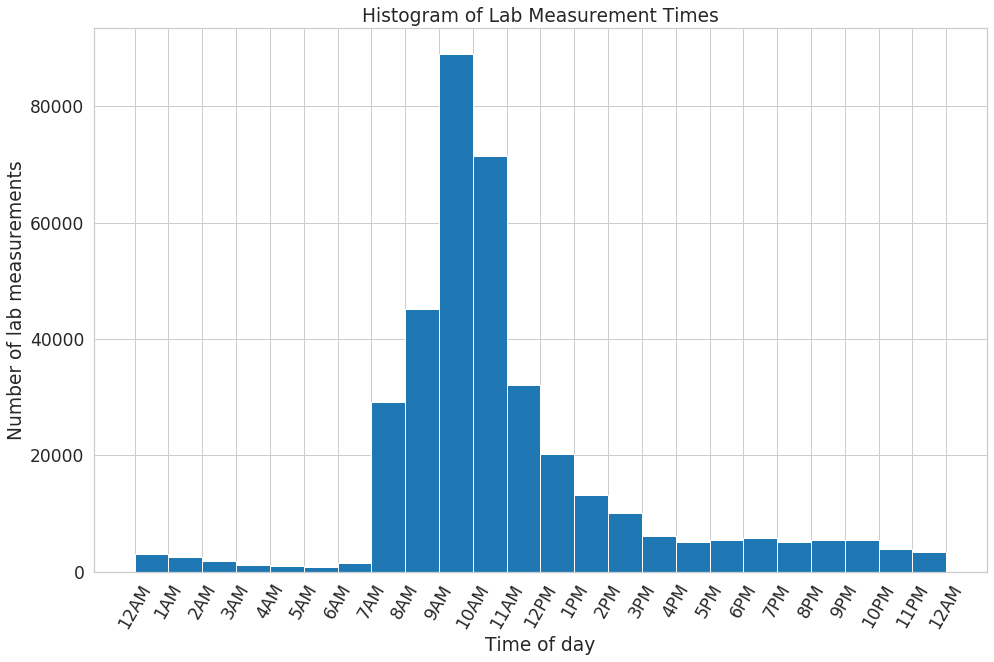

In [69]:

labs_ts = [i[11:] for i in labs_df['timestamp'].values]
labs_ts_hr = [int(ii[:2]) for ii in labs_ts]
bins=np.arange(0, 25)
xticks = bins
xticklabels = ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM',
              '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', '12AM']
f, axs = plt.subplots(1, 1, figsize=(16, 10))
sns.set_context("notebook", font_scale=1.55)
sns.set_style("whitegrid")
hist_vals = axs.hist(labs_ts_hr, bins=bins)
axs.set_xticks(xticks)
axs.set_xticklabels(xticklabels, rotation=60)
axs.set_title('Histogram of Lab Measurement Times')
axs.set_xlabel('Time of day')
axs.set_ylabel('Number of lab measurements')
f.savefig('lab_measurement_time_distribution.png')
plt.show()

In [70]:
hist_counts = hist_vals[0]
hist_bins = hist_vals[1]

In [77]:
dict(zip(xticklabels[1:], (np.cumsum(hist_counts)*100/hist_counts.sum()).round(2)))

{'1AM': 0.84,
 '2AM': 1.53,
 '3AM': 2.02,
 '4AM': 2.33,
 '5AM': 2.59,
 '6AM': 2.82,
 '7AM': 3.22,
 '8AM': 11.17,
 '9AM': 23.43,
 '10AM': 47.6,
 '11AM': 67.02,
 '12PM': 75.72,
 '1PM': 81.23,
 '2PM': 84.83,
 '3PM': 87.58,
 '4PM': 89.26,
 '5PM': 90.66,
 '6PM': 92.16,
 '7PM': 93.72,
 '8PM': 95.09,
 '9PM': 96.56,
 '10PM': 98.02,
 '11PM': 99.09,
 '12AM': 100.0}

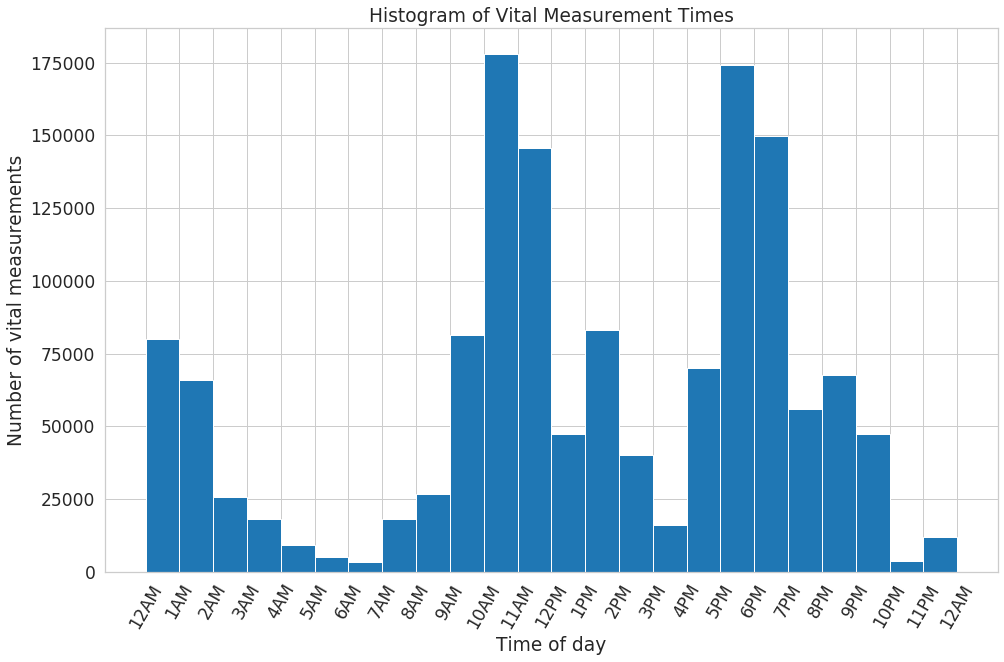

In [19]:
vitals_ts = [i[11:] for i in vitals_df['timestamp'].values]

vitals_ts_hr=[]
for ii in vitals_ts:
    if ii!='':
        vitals_ts_hr.append(int(ii[:2]))
    else:
        vitals_ts_hr.append(0)
    
    
# vitals_ts_hr = [ for ii in vitals_ts if ii!='' else 0]
bins=np.arange(0, 25)
xticks = bins
xticklabels = ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM',
              '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM', '12AM']
f, axs = plt.subplots(1, 1, figsize=(16, 10))
sns.set_context("notebook", font_scale=1.55)
sns.set_style("whitegrid")
hist_vals = axs.hist(vitals_ts_hr, bins=bins)
axs.set_xticks(xticks)
axs.set_xticklabels(xticklabels, rotation=60)
axs.set_title('Histogram of Vital Measurement Times')
axs.set_xlabel('Time of day')
axs.set_ylabel('Number of vital measurements')
axs.grid(True)
# f.savefig('vitals_measurement_time_distribution.png')
plt.show()

In [8]:
for jj, ii in enumerate(vitals_ts):
    print(int(ii[:2]))

12
17
17
1
2
10
12
17
17
0
0
10
10
0
7
14
17
18
0
7
10
12
17
20
0
7
10
13
18
1
7
10
12
18
0
6
10
17
20
3
11
13
20
20
2
10
13
18
21
21
0
10
14
17
20
2
10
13
18
20
1
11
14
17
21
21
1
14
14
17
21
2
11
11
14
18
20
21
2
13
13
19
1
9
13
20
4
11
13
17
21
1
10
13
17
20
2
10
13
19
20
0
11
13
17
20
2
10
9
16
0
3
10
12
11
19
20
21
3
10
11
18
0
12
13
18
19
3
3
17
0
0
11
18
19
0
0
12
13
10
17
17
23
0
9
11
17
18
1
2
9
10
21
0
10
17
1
9
17
10
18
11
11
13
17
18
20
10
13
13
17
17
20
11
11
13
18
20
8
11
13
17
18
20
9
11
13
18
18
20
9
10
17
18
20
8
10
13
18
20
2
12
14
18
20
12
15
1
11
14
14
17
18
21
9
13
14
17
19
20
9
10
13
17
17
20
8
11
13
17
19
20
1
11
13
17
19
4
11
13
17
20
0
11
14
18
20
11
13
17
20
10
12
17
21
11
13
17
20
0
11
0
10
14
18
18
20
3
10
13
14
18
18
20
3
9
10
14
16
16
20
1
11
12
13
17
17
20
0
9
12
17
17
20
10
11
14
15
17
21
9
10
14
17
17
20
8
10
11
13
16
17
20
3
9
10
13
13
17
17
20
2
10
10
14
0
11
13
13
16
18
2
10
11
16
19
3
9
11
13
17
18
18
21
1
9
10
13
17
19
21
0
10
10
1
12
13
14
17
21
2

ValueError: invalid literal for int() with base 10: ''

In [14]:
ii==''

True

In [18]:
vitals_df.iloc[1430:1438, :]

,patient_id,hospital_admission_id,facility_code,timestamp,hours_since_admission,heart_rate,body_temperature,systolic_blood_pressure,diastolic_blood_pressure,blood_glucose_concentration,bmi,weight,height,o2_sat,respiratory_rate
1430,1169,11023085,1,2020-09-26 13:59:13,14.287,NaN,36.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1431,1169,11023085,1,2020-09-26 17:27:33,17.759,NaN,35.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1432,1169,11023085,1,2020-09-26 17:37:51,17.931,81.0,NaN,116.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN
1433,1169,11023085,1,2020-09-27 00:30:13,24.804,NaN,36.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1434,1169,11023085,1,2020-09-27 02:56:16,27.238,71.0,NaN,100.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN
1435,1169,11023085,1,2020-09-27 10:05:25,34.390,73.0,NaN,106.0,68.0,NaN,NaN,NaN,NaN,NaN,NaN
1436,1205,19958988,1,2023-06-23 16:50:37,0.777,60.0,36.0,140.0,62.0,NaN,NaN,NaN,NaN,95.0,NaN
1437,1205,19958988,1,2023-06-24,7.933,58.0,35.0,104.0,52.0,NaN,NaN,NaN,NaN,92.0,NaN
